In [5]:
import pymc
import os
import rost
import pandas as pd
import scipy as sp
import matplotlib.gridspec as gridspec
from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext ipycache
%config InlineBackend.figure_format = 'svg'
exec(open('../settings.py').read(), globals())

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [6]:
cell_number_data_file = '../../data/cell_number_data.csv'
cell_number_data = pd.read_csv(cell_number_data_file)
cell_number_data = cell_number_data.sort_values(['time', 'ID'])
cell_number_data = cell_number_data.query('time != 2')
traces_path = './traces/'

In [7]:
cell_length = pd.read_csv('../../data/cell_length_data.csv')['cell_length'].mean()

In [8]:
outgrowth = pd.read_csv('../../data/outgrowth.csv')
mean_outgrowth = outgrowth.groupby('time').mean()['length']

In [9]:
# out_path = 'plots_{0}'.format(cell_number_data_file.split('.')[-2].split('/')[-1])
# rost.mkdir_p(out_path)

In [10]:
parameters = ['GF_left_pop', 'GF_right_pop', 'step_GF',  'mi_left_pop', 'mi_right_pop', 'step_mi',
               'switchpoint_pop', 'GF_sigma_inter', 'mi_sigma_inter', 'switchpoint_sigma_inter']

Check if there are fit results for all datasets

In [11]:
for time in cell_number_data['time'].unique():
    if os.path.isfile(os.path.join(traces_path, '{0}.h5'.format(time))):
        continue
    else:
        print('No data for time {0} days'.format(time))

In [12]:
def summary_bayesian(cell_number_data, parameter):
    summary = pd.DataFrame()
    summary.index.name = 'time'
    for time in cell_number_data['time'].unique():
        df = pd.read_hdf(os.path.join(traces_path, '{}.h5'.format(time)))
        trace = sp.array(df[parameter])
        summary.loc[time, 'mean'] = trace.mean()
        summary.loc[time, 'median'] = sp.median(trace)
        summary.loc[time, 'std']  = trace.std()
        for q in [0.135, 0.5, 1.0, 2.5, 5.0, 15.89, 84.11, 97.5, 100.0 - 0.5, 100.0 - 0.135]:
            summary.loc[time, '{0:.1f}'.format(q)]  = sp.percentile(trace, q)
    return summary

In [9]:
%%cache summary_bayes.pkl summary_bayes --cachedir ../cache/spatial
%%time
dfs = []
for parameter in parameters:
    data = summary_bayesian(cell_number_data, parameter).reset_index()
    data['parameter'] = parameter
    dfs.append(data.set_index(['parameter', 'time']))
summary_bayes = pd.concat(dfs)

[Skipped the cell's code and loaded variables summary_bayes from file '/media/500G/fabian/work/axolotl/git/axolotl-spinal-cord-regeneration-mechanism/jupyter/calculations/cache/spatial/summary_bayes.pkl'.]
CPU times: user 919 ms, sys: 92.5 ms, total: 1.01 s
Wall time: 1.01 s


In [10]:
summary_bayes.loc['switchpoint_pop']

,mean,median,std,0.1,0.5,1.0,2.5,5.0,15.9,84.1,97.5,99.5,99.9
time,,,,,,,,,,,,,
0,-1562.181469,-1743.047798,545.032864,-1999.337061,-1997.439041,-1994.861209,-1987.562151,-1975.357969,-1922.137531,-1430.026214,-37.074552,-7.321350,-1.965084
3,-787.511171,-772.952459,234.612444,-1796.058871,-1605.471504,-1468.702744,-1288.042691,-1171.680232,-1008.042067,-563.584527,-371.356288,-217.959627,-103.036293
4,-793.776048,-785.909634,130.329886,-1309.062885,-1223.331067,-1163.658284,-1084.045518,-1018.219482,-907.576900,-686.570460,-537.838226,-406.349583,-300.251354
6,-640.675506,-644.156954,140.800295,-1149.839969,-1059.491179,-1004.611820,-930.029680,-869.001241,-763.706832,-513.692644,-346.304499,-215.769379,-112.456066
8,-260.881878,-260.374077,187.545230,-877.500453,-776.082313,-717.278652,-634.872575,-568.858835,-442.908873,-77.965554,108.538058,244.981865,341.733040


In [11]:
ylabels = {'step_mi': 'step_mi',\
           
           'GF_left_pop': 'GF_left',\
           'mi_left_pop': 'mi_left',\
           'mi_right_pop': 'mi_right',\
           'SOX2_mean_left_pop': 'SOX2_mean',\
           'GF_right_pop': 'GF_right',\
           
           'step_GF': 'step_GF',\
           'switchpoint_pop': 'switchpoint (mm)',
           'N_q_right': 'N_q_right',
           'GF_sigma_inter': 'GF_sigma_inter',
           'mi_sigma_inter': 'mi_sigma_inter',
           'switchpoint_sigma_inter': 'switchpoint_sigma_inter',
          }

def summary_plot_bayesian(fig, ax, cell_number_data, parameter, **kwargs):
    bayesian = summary_bayes.loc[parameter].copy()
    if parameter == 'switchpoint_pop':
        bayesian = bayesian / 1000.0 # give in mm
        bayesian = bayesian.loc[4:] # significant step only from 4 days on
        
    
    for i, (time, row) in enumerate(bayesian.iterrows()):
        bayesian.loc[time, 'switch_min'] = -2000
        bayesian.loc[time, 'switch_max'] = mean_outgrowth[time]
        range_ = bayesian['97.5'].max() - bayesian['2.5'].min()
        max_ = bayesian['97.5'].max()
        y = max_ + range_ / 10.0
        if (row['2.5'] > 0.0) or (row['97.5'] < 0):
                bayesian.loc[time, 'significant'] = y
    bayesian = bayesian.reset_index()

    #plt.xticks(bayesian['x'], bayesian.index, rotation = 45)
    
    ax.set_xlim( -0.5, 8.5)

    ax.set_xlabel('Time (days)')
        
    ax.set_ylabel(ylabels[parameter])
    
    bayesian_errors = sp.array(\
                               (bayesian[['15.9', '84.1']].transpose() - bayesian['mean']).abs()\
                              )

    ax.errorbar(bayesian['time'], bayesian['mean'], bayesian_errors, **kwargs)
    
    

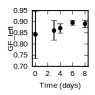

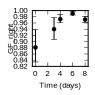

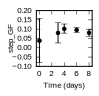

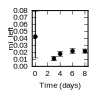

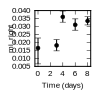

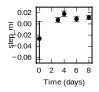

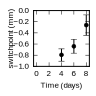

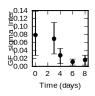

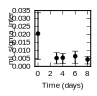

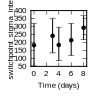

In [12]:
for parameter in parameters:
    fig, ax = plt.subplots(figsize = (1,1))
    summary_plot_bayesian(fig, ax, cell_number_data, parameter, color = 'black', fmt = 'o')
    plt.show()

## Significance of step

In [13]:
summary_bayes.loc['step_GF']

,mean,median,std,0.1,0.5,1.0,2.5,5.0,15.9,84.1,97.5,99.5,99.9
time,,,,,,,,,,,,,
0,0.037876,0.037803,0.111426,-0.269261,-0.234733,-0.211414,-0.173254,-0.139859,-0.080546,0.158813,0.240369,0.283078,0.302519
3,0.079690,0.082708,0.062082,-0.182656,-0.131915,-0.101389,-0.060724,-0.028764,0.026033,0.135026,0.197252,0.243391,0.273315
4,0.101727,0.103042,0.031882,-0.080742,-0.032856,-0.007856,0.028788,0.052460,0.078575,0.127690,0.159148,0.189029,0.216395
6,0.095100,0.095568,0.015128,-0.006679,0.031416,0.050346,0.066104,0.073673,0.083417,0.107648,0.121664,0.134761,0.150774
8,0.080284,0.079913,0.024141,-0.057447,-0.015699,0.006846,0.034486,0.046992,0.061939,0.099739,0.128168,0.156107,0.185987


There's $p<0.05$ (*) significant change in the GF of the posterior zone at day 4, 6 and 8.

There's $p<0.01$ (**) significant change in the GF of the posterior zone at day 6.

In [14]:
summary_bayes.loc['step_mi']

,mean,median,std,0.1,0.5,1.0,2.5,5.0,15.9,84.1,97.5,99.5,99.9
time,,,,,,,,,,,,,
0,-0.026183,-0.021993,0.032211,-0.095911,-0.092296,-0.089502,-0.084447,-0.079782,-0.064082,0.004877,0.028812,0.064457,0.081729
3,0.007008,0.006887,0.006200,-0.025267,-0.015848,-0.011184,-0.005339,-0.001679,0.002570,0.011586,0.019753,0.028171,0.036782
4,0.018148,0.018149,0.007088,-0.028327,-0.011485,-0.003057,0.005167,0.008871,0.013293,0.023152,0.032002,0.043273,0.053123
6,0.009105,0.009189,0.007541,-0.037014,-0.021909,-0.014774,-0.005877,-0.001150,0.004261,0.013952,0.024107,0.037917,0.050046
8,0.011640,0.011693,0.005765,-0.026654,-0.010530,-0.004632,0.001258,0.004184,0.007787,0.015475,0.021794,0.034426,0.045594


There's $p<0.05$ (*) significant increase in the mi of the posterior zone at day 4 & 8.

## Model results plot for paper

In [15]:
time = 8
df = pd.read_hdf(os.path.join(traces_path, '{}.h5'.format(time)))

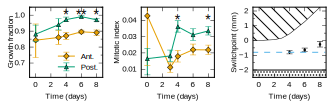

In [16]:
starhight = 1.00
starhight_m = 0.04
starsize = 14

fig, ax = plt.subplots(1, 3, figsize = (120.0 / 25.4, 40.0 / 25.4), sharex = True)


summary_plot_bayesian(fig, ax[0], cell_number_data, 'GF_left_pop', fmt = 'D-', color = colorcycle[1], label = 'Ant.')
summary_plot_bayesian(fig, ax[0], cell_number_data, 'GF_right_pop', fmt = '^-', color = colorcycle[3], label = 'Post.')

ax[0].text(4,starhight,'*',  ha = 'center',va='center',size = starsize)
ax[0].text(6,starhight,'**', ha = 'center',va='center',size = starsize)
ax[0].text(8,starhight,'*',  ha = 'center',va='center',size = starsize)
ax[0].set_ylim(0.61, 1.05)
ax[0].set_yticks(sp.arange(0.7, 1.01, 0.1))
ax[0].set_yticks(sp.arange(0.75, 1.06, 0.1), minor = True)

summary_plot_bayesian(fig, ax[1], cell_number_data, 'mi_left_pop', fmt = 'D-', color = colorcycle[1], label = 'anterior')
summary_plot_bayesian(fig, ax[1], cell_number_data, 'mi_right_pop', fmt = '^-', color = colorcycle[3], label = 'posterior')
ax[1].set_ylim(0.005, 0.048)
ax[1].set_yticks(sp.arange(0.01, 0.05, 0.01))
ax[1].text(4,starhight_m,'*',  ha = 'center',va='center',size = starsize)
ax[1].text(8,starhight_m,'*',  ha = 'center',va='center',size = starsize)

summary_plot_bayesian(fig, ax[2], cell_number_data, 'switchpoint_pop', fmt = '.', color = colorcycle[0])
ax[2].plot([-0.9, 8.7], 2* [-0.8], '--', color = colorcycle[2])
plot_mean_outgrowth = mean_outgrowth.copy()
plot_mean_outgrowth.loc[-1.0] = 0.0
plot_mean_outgrowth = plot_mean_outgrowth.reset_index()
plot_mean_outgrowth = plot_mean_outgrowth.sort_values('time')
plot_mean_outgrowth['length'] = plot_mean_outgrowth['length'] / 1000.0

ax[2].fill_between(plot_mean_outgrowth['time'], plot_mean_outgrowth['length'], 10.0, color = 'white', hatch = '\\\\', edgecolor = 'black', lw = 0.5)
ax[2].fill_between([-10.0, 10.0], 2 * [-2.0], -3.0, color = 'white', hatch = '....', edgecolor = 'black')
ax[2].set_ylim(-2.5, plot_mean_outgrowth['length'].max())
ax[2].set_yticks(sp.arange(-1.5, 1.6, 1), minor = True)

ax[0].set_ylabel('Growth fraction')
ax[1].set_ylabel('Mitotic index', labelpad = 8)
ax[2].set_ylabel('Switchpoint (mm)')

ax[0].set_xlim(-0.8, 8.8)

ax[0].legend(loc = (0.35, 0.05), frameon = False, ncol = 1, numpoints = 1)

plt.tight_layout()
plt.savefig('../../figure_plots/Fig2_model_results.svg')
plt.show()

## Final plots for Figure 2

number of SOX2+ cells per cross section

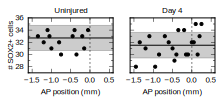

In [17]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = 'row', figsize = (85.0 / 25.4, 25.0 / 25.4), squeeze=False)
fig.patch.set_alpha(1.0)

for i, ID in enumerate(['0D_1', '4D_3']):

    data = cell_number_data.query('ID == @ID')
    ctime = data['time'].iloc[0]

    # plot data
    ax[0,i].scatter(data['pos'] / 1000.0, data['SOX2'], color = 'black', label = 'data', s = 10)

    # plot model
    x = sp.array([-2, 1]) 
    SOX2 = data['SOX2'].mean()
    SOX2_delta = data['SOX2'].std()

    ax[0,i].plot(x, 2* [SOX2], color = 'black', label = 'mean')
    ax[0,i].fill_between(x, 2 * [SOX2 - SOX2_delta], 2 * [SOX2 + SOX2_delta], alpha = 0.2, color = 'black', label = 'conf.belt')
    
    ax[0,i].plot([0, 0], [0, 40], 'k:')
    
    
# ax[1,1].plot(x, 2* [GF_left*SOX2] + 2 * [GF_right*SOX2])
# ax[2,1].plot(x, 2* [50.0/cell_length*mi_left*GF_left*SOX2] + 2 * [50.0/cell_length*mi_right*GF_right*SOX2])

# title
ax[0,0].set_title('Uninjured', fontsize = 8)
ax[0,1].set_title('Day 4', fontsize = 8)

# labels
ax[0,0].set_xlabel('AP position (mm)')
ax[0,1].set_xlabel('AP position (mm)')

ax[0,0].set_ylabel('# SOX2+ cells')

# limits
ax[0,0].set_xlim(-1.6, 0.6)
# ax[0,0].set_xticks([-1.5, -0.5, 0.5])
# ax[0,0].set_xticks([-1.0, 0.0], minor = True)
ax[0,0].set_ylim(27, 36)
ax[0,0].set_yticks(sp.arange(28, 37, 2))
ax[0,0].set_yticks(sp.arange(27, 36, 2), minor = True)

# legend
# ax[0, 0].legend(loc = 'lower left', frameon = False)

plt.savefig('../../figure_plots/Fig2_stem_cells_section.svg')

plt.show()

PCNA and mitosis 

In [18]:
def mean_fit(time):
    df = pd.read_hdf(os.path.join(traces_path, '{}.h5'.format(time)))
    switchpoint = df['switchpoint_pop'].mean()
    GF_left = df['GF_left_pop'].mean()
    GF_right = df['GF_right_pop'].mean()
    mi_left = df['mi_left_pop'].mean()
    mi_right = df['mi_right_pop'].mean()
    return switchpoint, GF_left, GF_right, mi_left, mi_right

In [19]:
def best_fit(time):
    df = pd.read_hdf(os.path.join(traces_path, '{}.h5'.format(time)))
    bestfitarg = df['deviance'].argmin()
    switchpoint = sp.array(df['switchpoint_pop'])[bestfitarg]
    GF_left = sp.array(df['GF_left_pop'])[bestfitarg]
    GF_right = sp.array(df['GF_right_pop'])[bestfitarg]
    mi_left = sp.array(df['mi_left_pop'])[bestfitarg]
    mi_right = sp.array(df['mi_right_pop'])[bestfitarg]
    return switchpoint, GF_left, GF_right, mi_left, mi_right

In [20]:
plt.xlabel?

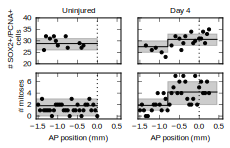

In [21]:
fig, ax = plt.subplots(2, 2, sharex = True, sharey = 'row', figsize = (85.0 / 25.4, 46.0 / 25.4))
fig.patch.set_alpha(1.0)

for i, ID in enumerate(['0D_1', '4D_3']):

    data = cell_number_data.query('ID == @ID')
    ctime = data['time'].iloc[0]
    

#     ax[0,i].set_title(ID)    
    # plot data
    ax[0,i].scatter(data['pos'] / 1000.0, data['PCNA'], color = 'black', s = 10)
    ax[1,i].scatter(data['pos'] / 1000.0, data['m'], color = 'black', s = 10)

    # plot model
    switchpoint, GF_left, GF_right, mi_left, mi_right = mean_fit(ctime)
    switchpoint /= 1000.0
    x = sp.array([-2, switchpoint, switchpoint, mean_outgrowth[ctime] / 1000.0]) 
    SOX2 = data['SOX2'].mean()

    ax[0,i].plot(x, 2* [GF_left*SOX2] + 2 * [GF_right*SOX2], color = 'black')
    ax[1,i].plot(x, 2* [50.0/cell_length*mi_left*GF_left*SOX2] + 2 * [50.0/cell_length*mi_right*GF_right*SOX2], color = 'black')
    
    # confidence belt
    sp.random.seed(0)
    SOX2_delta = data['SOX2'].std()
    Nsamples = 100000
    NSOX2 = sp.around(sp.random.normal(SOX2, SOX2_delta, Nsamples)).astype(int)
    NPCNA_left = sp.random.binomial(NSOX2, GF_left)
    Nm_left = sp.random.binomial(sp.around(50.0/cell_length*NPCNA_left).astype(int), mi_left)
    NPCNA_right = sp.random.binomial(NSOX2, GF_right)
    Nm_right = sp.random.binomial(sp.around(50.0/cell_length*NPCNA_right).astype(int), mi_right)
    
    ax[0,i].plot([0, 0], [0, 40], 'k:')
    ax[1,i].plot([0, 0], [0, 40], 'k:')
    
#     ax[0,i].fill_between(x, 2* [NPCNA_left.mean() + NPCNA_left.std()] + 2 * [NPCNA_right.mean() + NPCNA_right.std()],\
#                             2* [NPCNA_left.mean() - NPCNA_left.std()] + 2 * [NPCNA_right.mean() - NPCNA_right.std()],\
#                          alpha = 0.2, color = 'black', label = 'conf.belt')
    
#     ax[1,i].fill_between(x, 2* [Nm_left.mean() + Nm_left.std()] + 2 * [Nm_right.mean() + Nm_right.std()],\
#                             2* [Nm_left.mean() - Nm_left.std()] + 2 * [Nm_right.mean() - Nm_right.std()],\
#                          alpha = 0.2, color = 'black', label = 'conf.belt')
    
    ax[0,i].fill_between(x, 2* [sp.percentile(NPCNA_left, 100 - 0.5 * (100 - 68))] + 2 * [sp.percentile(NPCNA_right, 100 - 0.5 * (100 - 68))],\
                    2* [sp.percentile(NPCNA_left, 0.5 * (100 - 68))] + 2 * [sp.percentile(NPCNA_right, 0.5 * (100 - 68))],\
                 alpha = 0.2, color = 'black', label = 'conf.belt')
    
    
    ax[1,i].fill_between(x, 2* [sp.percentile(Nm_left, 100 - 0.5 * (100 - 68))] + 2 * [sp.percentile(Nm_right, 100 - 0.5 * (100 - 68))],\
                        2* [sp.percentile(Nm_left, 0.5 * (100 - 68))] + 2 * [sp.percentile(Nm_right, 0.5 * (100 - 68))],\
                     alpha = 0.2, color = 'black', label = 'conf.belt')
    
# ax[1,1].plot(x, 2* [GF_left*SOX2] + 2 * [GF_right*SOX2])
# ax[2,1].plot(x, 2* [50.0/cell_length*mi_left*GF_left*SOX2] + 2 * [50.0/cell_length*mi_right*GF_right*SOX2])

# title
ax[0,0].set_title('Uninjured', fontsize = 8)
ax[0,1].set_title('Day 4', fontsize = 8)

# labels
ax[1,0].set_xlabel('AP position (mm)')
ax[1,1].set_xlabel('AP position (mm)')

ax[0,0].set_ylabel('               # SOX2+/PCNA+\ncells', horizontalalignment = 'center')
ax[1,0].set_ylabel('# mitoses')

# limits
ax[0,0].set_xlim(-1.55, 0.6)
ax[0,0].set_ylim(20, 40)
ax[1,0].set_ylim(-0.5, 7.5)
ax[1,0].set_yticks(sp.arange(0, 7, 2))
# ax[1,0].set_yticks(sp.arange(1, 8, 2), minor = True)

plt.savefig('../../figure_plots/Fig2_proliferative_mitosis_section.svg')

plt.show()

without model

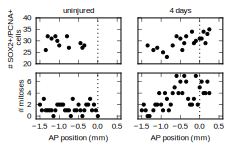

In [22]:
fig, ax = plt.subplots(2, 2, sharex = True, sharey = 'row', figsize = (85.0 / 25.4, 46.0 / 25.4))
fig.patch.set_alpha(1.0)

for i, ID in enumerate(['0D_1', '4D_3']):

    data = cell_number_data.query('ID == @ID')
    ctime = data['time'].iloc[0]
    

#     ax[0,i].set_title(ID)    
    # plot data
    ax[0,i].scatter(data['pos'] / 1000.0, data['PCNA'], color = 'black', s = 10)
    ax[1,i].scatter(data['pos'] / 1000.0, data['m'], color = 'black', s = 10)

    # plot model
    switchpoint, GF_left, GF_right, mi_left, mi_right = best_fit(ctime)
    switchpoint /= 1000.0
    x = sp.array([-2, switchpoint, switchpoint, mean_outgrowth[ctime] / 1000.0]) 
    SOX2 = data['SOX2'].mean()

#     ax[0,i].plot(x, 2* [GF_left*SOX2] + 2 * [GF_right*SOX2], color = 'black')
#     ax[1,i].plot(x, 2* [50.0/cell_length*mi_left*GF_left*SOX2] + 2 * [50.0/cell_length*mi_right*GF_right*SOX2], color = 'black')
    
    # confidence belt
    sp.random.seed(0)
    SOX2_delta = data['SOX2'].std()
    Nsamples = 100000
    NSOX2 = sp.around(sp.random.normal(SOX2, SOX2_delta, Nsamples)).astype(int)
    NPCNA_left = sp.random.binomial(NSOX2, GF_left)
    Nm_left = sp.random.binomial(sp.around(50.0/cell_length*NPCNA_left).astype(int), mi_left)
    NPCNA_right = sp.random.binomial(NSOX2, GF_right)
    Nm_right = sp.random.binomial(sp.around(50.0/cell_length*NPCNA_right).astype(int), mi_right)
    
    ax[0,i].plot([0, 0], [0, 40], 'k:')
    ax[1,i].plot([0, 0], [0, 40], 'k:')
    
#     ax[0,i].fill_between(x, 2* [NPCNA_left.mean() + NPCNA_left.std()] + 2 * [NPCNA_right.mean() + NPCNA_right.std()],\
#                             2* [NPCNA_left.mean() - NPCNA_left.std()] + 2 * [NPCNA_right.mean() - NPCNA_right.std()],\
#                          alpha = 0.2, color = 'black', label = 'conf.belt')
    
#     ax[1,i].fill_between(x, 2* [Nm_left.mean() + Nm_left.std()] + 2 * [Nm_right.mean() + Nm_right.std()],\
#                             2* [Nm_left.mean() - Nm_left.std()] + 2 * [Nm_right.mean() - Nm_right.std()],\
#                          alpha = 0.2, color = 'black', label = 'conf.belt')
    
#     ax[0,i].fill_between(x, 2* [sp.percentile(NPCNA_left, 100 - 0.5 * (100 - 68))] + 2 * [sp.percentile(NPCNA_right, 100 - 0.5 * (100 - 68))],\
#                     2* [sp.percentile(NPCNA_left, 0.5 * (100 - 68))] + 2 * [sp.percentile(NPCNA_right, 0.5 * (100 - 68))],\
#                  alpha = 0.2, color = 'black', label = 'conf.belt')
    
    
#     ax[1,i].fill_between(x, 2* [sp.percentile(Nm_left, 100 - 0.5 * (100 - 68))] + 2 * [sp.percentile(Nm_right, 100 - 0.5 * (100 - 68))],\
#                         2* [sp.percentile(Nm_left, 0.5 * (100 - 68))] + 2 * [sp.percentile(Nm_right, 0.5 * (100 - 68))],\
#                      alpha = 0.2, color = 'black', label = 'conf.belt')
    
# ax[1,1].plot(x, 2* [GF_left*SOX2] + 2 * [GF_right*SOX2])
# ax[2,1].plot(x, 2* [50.0/cell_length*mi_left*GF_left*SOX2] + 2 * [50.0/cell_length*mi_right*GF_right*SOX2])

# title
ax[0,0].set_title('uninjured', fontsize = 8)
ax[0,1].set_title('4 days', fontsize = 8)

# labels
ax[1,0].set_xlabel('AP position (mm)')
ax[1,1].set_xlabel('AP position (mm)')

ax[0,0].set_ylabel('               # SOX2+/PCNA+\ncells')
ax[1,0].set_ylabel('# mitoses')

# limits
ax[0,0].set_xlim(-1.6, 0.6)
ax[0,0].set_ylim(20, 40)
ax[1,0].set_ylim(-0.5, 7.5)
ax[1,0].set_yticks(sp.arange(0, 7, 2))
# ax[1,0].set_yticks(sp.arange(1, 8, 2), minor = True)

plt.savefig('../../figure_plots/Fig2_proliferative_mitosis_section_without_model.svg')

plt.show()

## Supplementary figures

Plot SOX2+ cells per cross section for all animals

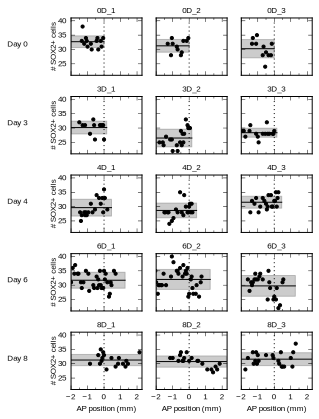

In [23]:
figheight = 150 # max on A4 is 297.0 - 25 - 20
figwidth = 100 # max on A4 is 210.0 -25 - 25 - 10
fig, ax = plt.subplots(5, 3, sharex = True, sharey = 'row', figsize = (figwidth/ 25.4, figheight / 25.4), squeeze=False)
time_row = {0: 0, 3: 1, 4: 2, 6: 3, 8: 4}

for ID in cell_number_data['ID'].unique():
    data = cell_number_data.query('ID == @ID')
    ctime = data['time'].iloc[0]
    i = time_row[ctime]
    j = int(ID[-1]) - 1
    
     # plot data
    ax[i, j].scatter(data['pos'] / 1000.0, data['SOX2'], color = 'black', label = 'data', s = 10)

    # plot model
    x = sp.array([-2, mean_outgrowth[ctime] / 1000.0]) 
    SOX2 = data['SOX2'].mean()
    SOX2_delta = data['SOX2'].std()

    ax[i, j].plot(x, 2* [SOX2], color = 'black', label = 'mean')
    ax[i, j].fill_between(x, 2 * [SOX2 - SOX2_delta], 2 * [SOX2 + SOX2_delta], alpha = 0.2, color = 'black', label = 'conf.belt')
    
    ax[i, j].plot([0, 0], [0, 40], 'k:')
    
    if j == 0:
        ax[i, j].set_ylabel('# SOX2+ cells')
        ax[i, j].text(-0.9, 0.5, 'Day {}'.format(ctime), transform = ax[i, j].transAxes, fontsize = 8)
    
    if ctime == 8:
        ax[i, j].set_xlabel('AP position (mm)')
        ax[i, j].set_xticks(sp.arange(-2, 2.1, 1))
        ax[i, j].set_xticks(sp.arange(-1.5, 1.6, 1), minor = True)
    ax[i, j].set_ylim(21, 41)
    ax[i, j].set_title(ID, fontsize = 8)
    
ax[i, j].set_xlim(-2, 2.3)

plt.tight_layout()
plt.savefig('../../figure_plots/supplement_stem_cells_section.svg')
plt.show()

Plot proliferative cells, mitosis and mean model fit for all animals.

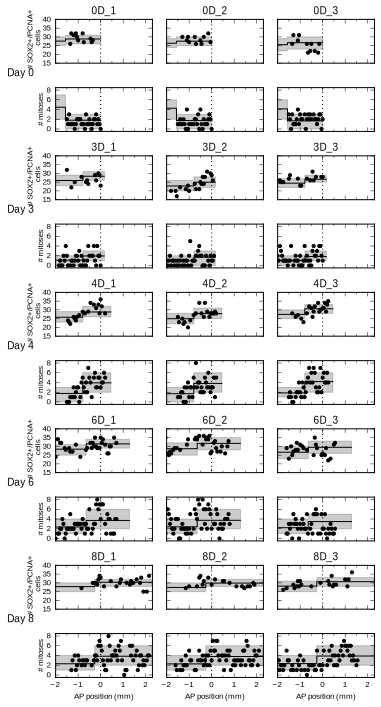

In [24]:
figheight = 297.0 - 25 - 20
figwidth = 130 # max on A4 is 210.0 -25 - 25 - 10
fig, ax = plt.subplots(2 * 5, 3, sharex = True, sharey = 'row', figsize = (figwidth/ 25.4, figheight / 25.4), squeeze=False)
time_row = {0: 0, 3: 1, 4: 2, 6: 3, 8: 4}

for ID in cell_number_data['ID'].unique():
    data = cell_number_data.query('ID == @ID')
    ctime = data['time'].iloc[0]
    i_proliferative = 2 * time_row[ctime]
    i_mitosis = 2 * time_row[ctime] + 1
    j = int(ID[-1]) - 1
    
    # plot data
    ax[i_proliferative, j].scatter(data['pos'] / 1000.0, data['PCNA'], color = 'black', s = 10)
    ax[i_mitosis, j].scatter(data['pos'] / 1000.0, data['m'], color = 'black', s = 10)

    # plot model
    switchpoint, GF_left, GF_right, mi_left, mi_right = mean_fit(ctime)
    switchpoint /= 1000.0
    x = sp.array([-2, switchpoint, switchpoint, mean_outgrowth[ctime] / 1000.0]) 
    SOX2 = data['SOX2'].mean()

    ax[i_proliferative, j].plot(x, 2* [GF_left*SOX2] + 2 * [GF_right*SOX2], color = 'black')
    ax[i_mitosis, j].plot(x, 2* [50.0/cell_length*mi_left*GF_left*SOX2] + 2 * [50.0/cell_length*mi_right*GF_right*SOX2], color = 'black')
    
    # confidence belt
    sp.random.seed(0)
    SOX2_delta = data['SOX2'].std()
    Nsamples = 100000
    NSOX2 = sp.around(sp.random.normal(SOX2, SOX2_delta, Nsamples)).astype(int)
    NPCNA_left = sp.random.binomial(NSOX2, GF_left)
    Nm_left = sp.random.binomial(sp.around(50.0/cell_length*NPCNA_left).astype(int), mi_left)
    NPCNA_right = sp.random.binomial(NSOX2, GF_right)
    Nm_right = sp.random.binomial(sp.around(50.0/cell_length*NPCNA_right).astype(int), mi_right)
    
    ax[i_proliferative, j].plot([0, 0], [0, 40], 'k:')
    ax[i_mitosis, j].plot([0, 0], [0, 40], 'k:')
    
    ax[i_proliferative, j].fill_between(x, 2* [sp.percentile(NPCNA_left, 100 - 0.5 * (100 - 68))] + 2 * [sp.percentile(NPCNA_right, 100 - 0.5 * (100 - 68))],\
                    2* [sp.percentile(NPCNA_left, 0.5 * (100 - 68))] + 2 * [sp.percentile(NPCNA_right, 0.5 * (100 - 68))],\
                 alpha = 0.2, color = 'black', label = 'conf.belt')
    
    
    ax[i_mitosis, j].fill_between(x, 2* [sp.percentile(Nm_left, 100 - 0.5 * (100 - 68))] + 2 * [sp.percentile(Nm_right, 100 - 0.5 * (100 - 68))],\
                        2* [sp.percentile(Nm_left, 0.5 * (100 - 68))] + 2 * [sp.percentile(Nm_right, 0.5 * (100 - 68))],\
                     alpha = 0.2, color = 'black', label = 'conf.belt')
    
    if j == 0:
        ax[i_proliferative, 0].set_ylabel('               # SOX2+/PCNA+\ncells')
        ax[i_mitosis, 0].set_ylabel('# mitoses')
        ax[i_proliferative, 0].text(-0.5, -0.3, 'Day {}'.format(ctime), transform = ax[i_proliferative, 0].transAxes, fontsize = 10)
    
    if ctime == 8:
        ax[i_mitosis,j].set_xlabel('AP position (mm)')
        ax[i_mitosis,j].set_xticks(sp.arange(-2, 2.1, 1))
        ax[i_mitosis,j].set_xticks(sp.arange(-1.5, 1.6, 1), minor = True)
    
    # title
    ax[i_proliferative,j].set_title(ID, fontsize = 10)
    
    # limits
    ax[i_proliferative, j].set_xlim(-2, 2.3)
#     ax[i_proliferative, j].set_xticklabels([])
    ax[i_mitosis, j].set_xlim(-2, 2.3)
    ax[i_proliferative, j].set_ylim(15, 40)
    ax[i_mitosis, j].set_ylim(-0.5, 8.5)

    
plt.tight_layout()
plt.savefig('../../figure_plots/supplement_proliferative_mitosis.png', dpi = 300)
plt.savefig('../../figure_plots/supplement_proliferative_mitosis.svg')
plt.show()

Plotting the marginal distributions

In [25]:
dfs = {}
for time in cell_number_data['time'].unique():
    dfs[time] = pd.read_hdf(os.path.join(traces_path, '{}.h5'.format(time)))
    
parameters = ['GF_left_pop', 'GF_right_pop', 'step_GF',  'mi_left_pop', 'mi_right_pop', 'step_mi',
               'switchpoint_pop', 'GF_sigma_inter', 'mi_sigma_inter', 'switchpoint_sigma_inter']
parameter_names = { 'switchpoint_pop': 'switchpoint',
                    'step_GF': u'ΔGF',
                    'step_mi': u'Δmi',
                    'GF_left_pop': 'GF anterior',
                    'GF_right_pop': 'GF posterior',
                    'mi_left_pop': 'mi anterior',
                    'mi_right_pop': 'mi posterior',
                    'GF_sigma_inter': u'σ GF',
                    'mi_sigma_inter': u'σ mi',
                    'switchpoint_sigma_inter': u'σ switchpoint'}

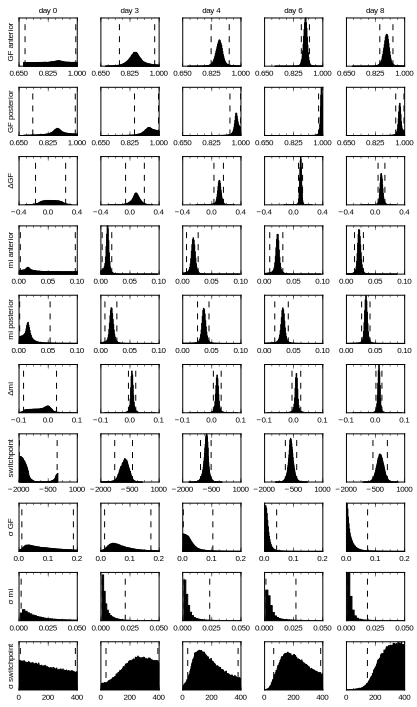

In [26]:
figheight = 297.0 - 25 - 20
figwidth = 210.0 -25 - 25 - 10
fig, ax = plt.subplots(len(parameters), len(cell_number_data['time'].unique()),
                       sharex = 'row', sharey = 'row', figsize = (figwidth/ 25.4, figheight / 25.4))

for i, parameter in enumerate(parameters):
    ax[i, 0].set_ylabel(parameter_names[parameter])
    ax[i, 0].set_yticks([])
    maxy = 0
    for j, time in enumerate(cell_number_data['time'].unique()):
        if i == 0:
            ax[i, j].set_title('day {}'.format(time), fontsize = 8)
        
        y = ax[i, j].hist(sp.array(dfs[time][parameter]), 100, normed = True, color = 'black')[0]
        maxy = max(maxy, y.max())
        
    for j, time in enumerate(cell_number_data['time'].unique()):
        ax[i, j].plot(2 * [sp.percentile(sp.array(dfs[time][parameter]), 2.5)], [0, maxy], 'k--')
        ax[i, j].plot(2 * [sp.percentile(sp.array(dfs[time][parameter]), 97.5)], [0, maxy], 'k--')
        
    if parameter == 'mi_sigma_inter':
        ax[i, j].set_xlim(0, 0.05)

    ax[i, j].xaxis.set_major_locator(ticker.LinearLocator(3))
    ax[i, j].xaxis.set_minor_locator(ticker.LinearLocator(9))
    
plt.tight_layout()
plt.savefig('../../figure_plots/supplement_marginals.svg')
plt.show()